<a href="https://colab.research.google.com/github/Jin-jin-jara/Deep-Learning/blob/master/rnn_2_number_with_blank(LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

TensorFlow 2.x selected.


In [0]:
tf.keras.backend.set_floatx('float32')

In [0]:
x, y = load_digits(return_X_y=True)
x.shape, y.shape, set(y)

((1797, 64), (1797,), {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

학습데이터와 테스트 데이터를 나눕니다

In [0]:
m = len(y)//2
x_train = x[:m]
y_train = y[:m]
x_test = x[m:m*2]
y_test = y[m:m*2]
x_test.shape, y_test.shape

((898, 64), (898,))

In [0]:
def convert_2_num(x_test, y_test):
  x_test = np.reshape(x_test, [-1, 8, 8])
  x_test_l, x_test_r = np.split(x_test, 2, axis=0) 
  x_test_lr = np.concatenate((x_test_l, x_test_r), axis=2)
  y_test_l, y_test_r = np.split(y_test, 2, axis=0) 
  y_test = np.stack((y_test_l, y_test_r), -1)

  #우측에 비어있는 이미지를 붙여서 한자리수 데이터를 만듭니다
  BLANK = 10 #'없음' 을 나타내는 기호
  x_test_blank = np.concatenate((x_test_l, np.zeros_like(x_test_r)), axis=2)
  y_test_blank = np.stack((y_test_l, np.zeros_like(y_test_l) + BLANK), 1)#좌측 영상의 y와 빈 영상의 y를 통합

  #두자리수 데이터와 한자리수 데이터를 통합합니다
  x_test_set = np.concatenate((x_test_lr, x_test_blank), 0)# 두자리수 영상과 한자리수 영상을 통합
  y_test_set = np.concatenate((y_test, y_test_blank), 0)#두자리수 y와 한자리수 y 를 통합
  return x_test_set,  y_test_set  

In [0]:
x_test_set,  y_test_set = convert_2_num(x_test, y_test)
x_train_set,  y_train_set = convert_2_num(x_train, y_train)

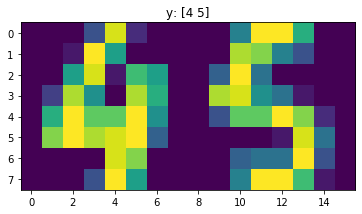

In [0]:
i = 11
plt.title('y: '+str(y_test_set[i]))
plt.imshow(x_test_set[i].reshape((8,-1)))

In [0]:
class MyModel(keras.Model): # github.com/sogangori/choongang20/ 
  def __init__(self):    
    super(MyModel, self).__init__()
    self.k = 10+1 # 클래스 갯수 
    self.seq = 2 # 자릿수
    self.opt = tf.optimizers.Nadam(learning_rate=0.008)#Stochatic Gradient Descent 확률적 경사 하강
    self.conv0 = keras.layers.Conv2D(32, [3,3], padding='same', activation=keras.activations.relu)
    self.conv1 = keras.layers.Conv2D(64, [3,3], padding='same', activation=keras.activations.relu)
    self.pool0 = keras.layers.MaxPool2D([2,2], padding='same')
    self.pool1 = keras.layers.MaxPool2D([2,2], padding='same')    
    self.rnn = keras.layers.LSTM(units=self.k, return_sequences=True)
  
  def call(self, x):
    #x (1797, 64)
    x_4d = tf.reshape(x, [-1,8,8*2,1]) 
    x_4d = tf.cast(x_4d, tf.float32)
    net = self.conv0(x_4d)
    net = self.pool0(net)#(4,8,16)
    net = self.conv1(net)
    net = self.pool1(net)#(2,4,32)
    net = self.pool1(net)#(1,2,32)
    net = tf.squeeze(net, axis=1)#(2,32)
    h = self.rnn(net)#(2,10)        
    h = tf.nn.softmax(h, axis=2)
    return h

  def get_loss(self, y, h):
    #학습할때 nan이 발생하는 경우 값을 clip(자르다) (최소값, 최대값) 
    h = tf.clip_by_value(h, 1e-8, 1 - 1e-8) # h 가 0이나 1이 되지 않도록 하는 안전장치 
    cross_entropy = - (y * tf.math.log(h) + (1 - y) * tf.math.log(1 - h)) 
    loss = tf.reduce_mean(cross_entropy)
    return loss

  def get_accuracy(self, y, h):    
    predict = tf.argmax(h, -1)
    is_equal = tf.equal(y, predict)
    self.acc = tf.reduce_mean(tf.cast(is_equal, tf.float32)) # True > 1, False > 0 로 cast
    self.acc_all = tf.reduce_mean(tf.cast(tf.reduce_all(is_equal, axis=1), tf.float32))

  def fit(self, x, y, epoch=1):
    # x : (m, 8, 16), y: (m, 2)    
    y_hot = tf.one_hot(y, depth=self.k, axis=-1)#(m, 2, 10)  
    for i in range(epoch):
      with tf.GradientTape() as tape: #경사 기록 장치
        h = self.call(x)
        loss = self.get_loss(y_hot, h)        
      grads = tape.gradient(loss, self.trainable_variables) #경사 계산
      #경사가 너무 크면 nan 이 될 수 있으므로 gradient cliping (최소,최대값 제한) 을 합니다
      grads = [(tf.clip_by_value(grad, -5.0, 5.0)) for grad in grads]      
      self.opt.apply_gradients(zip(grads, self.trainable_variables)) # 가중치에서 경사를 빼기
      self.get_accuracy(y, h)
      if i%10==0:
        print('%d/%d loss:%.3f acc:%.3f acc_all:%.3f'%(i, epoch, loss, self.acc, self.acc_all))
model = MyModel()

In [0]:
model.fit(x_train_set, y_train_set, epoch=6000) #학습 

0/6000 loss:0.308 acc:0.225 acc_all:0.000
10/6000 loss:0.268 acc:0.326 acc_all:0.059
20/6000 loss:0.256 acc:0.391 acc_all:0.120
30/6000 loss:0.240 acc:0.398 acc_all:0.129
40/6000 loss:0.230 acc:0.402 acc_all:0.133
50/6000 loss:0.227 acc:0.403 acc_all:0.134
60/6000 loss:0.226 acc:0.403 acc_all:0.134
70/6000 loss:0.225 acc:0.403 acc_all:0.134
80/6000 loss:0.225 acc:0.403 acc_all:0.134
90/6000 loss:0.224 acc:0.403 acc_all:0.134
100/6000 loss:0.224 acc:0.403 acc_all:0.134
110/6000 loss:0.224 acc:0.403 acc_all:0.134
120/6000 loss:0.224 acc:0.403 acc_all:0.134
130/6000 loss:0.224 acc:0.403 acc_all:0.134
140/6000 loss:0.224 acc:0.403 acc_all:0.134
150/6000 loss:0.224 acc:0.403 acc_all:0.134
160/6000 loss:0.224 acc:0.403 acc_all:0.134
170/6000 loss:0.224 acc:0.403 acc_all:0.134
180/6000 loss:0.224 acc:0.403 acc_all:0.134
190/6000 loss:0.224 acc:0.403 acc_all:0.134
200/6000 loss:0.224 acc:0.403 acc_all:0.134
210/6000 loss:0.224 acc:0.403 acc_all:0.134
220/6000 loss:0.224 acc:0.403 acc_all:0.134

In [0]:
# 테스트셋의 성능
h = model(x_test_set)
model.get_accuracy(y_test_set, h)
print('개별정확도',model.acc.numpy(),'두자리 모두 맞춘 정확도', model.acc_all.numpy())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

개별정확도 0.69432074 두자리 모두 맞춘 정확도 0.4766147


In [0]:
class MyModel(keras.Model): # github.com/sogangori/choongang20/ 
  def __init__(self):    
    super(MyModel, self).__init__()
    self.k = 10+1 # 클래스 갯수 
    self.seq = 2 # 자릿수
    self.opt = tf.optimizers.Nadam(learning_rate=0.001)#Stochatic Gradient Descent 확률적 경사 하강
    self.conv0 = keras.layers.Conv2D(16, [3,3], padding='same', activation=keras.activations.relu)
    self.conv1 = keras.layers.Conv2D(32, [3,3], padding='same', activation=keras.activations.relu)
    self.pool0 = keras.layers.MaxPool2D([2,2], padding='same')
    self.pool1 = keras.layers.MaxPool2D([2,2], padding='same')    
    self.rnn = keras.layers.LSTM(units=self.k, return_sequences=True)
    # self.rnn = keras.layers.GRU(units=self.k, return_sequences=True) # 조경현&요슈야 벤지오 2015
    # self.rnn = keras.layers.Bidirectional(keras.layers.LSTM(units=self.k, return_sequences=True))
  
  def call(self, x):
    #x (1797, 64)
    x_4d = tf.reshape(x, [-1,8,8*2,1]) 
    x_4d = tf.cast(x_4d, tf.float32)
    net = self.conv0(x_4d)
    net = self.pool0(net)#(4,8,16)
    net = self.conv1(net)
    net = self.pool1(net)#(2,4,32)
    net = self.pool1(net)#(1,2,32)
    # net = tf.reduce_sum(net, axis=1)  # (4, 32)
    net = tf.squeeze(net, axis=1)#(2,32)  2: 2개의 시퀀스 
    h = self.rnn(net)#(2,11)  # return_sequence=True 를 했기 때문에 h값에 아웃풋값 2개가 들어간다      
    # h = self.rnn(net) # (4,11) 4개의 아웃풋
    # h = h[:, 2:]  # 앞에 2개의 output은 버리고 뒤의 2개의 output만 사용
    h = tf.nn.softmax(h, axis=2) 
    return h

  def get_loss(self, y, h):
    #학습할때 nan이 발생하는 경우 값을 clip(자르다) (최소값, 최대값) 
    h = tf.clip_by_value(h, 1e-8, 1 - 1e-8) # h 가 0이나 1이 되지 않도록 하는 안전장치 
    cross_entropy = - (y * tf.math.log(h) + (1 - y) * tf.math.log(1 - h)) 
    loss = tf.reduce_mean(cross_entropy)
    return loss

  def get_accuracy(self, y, h):    
    predict = tf.argmax(h, -1)
    is_equal = tf.equal(y, predict)
    self.acc = tf.reduce_mean(tf.cast(is_equal, tf.float32)) # True > 1, False > 0 로 cast
    self.acc_all = tf.reduce_mean(tf.cast(tf.reduce_all(is_equal, axis=1), tf.float32))

  def fit(self, x, y, epoch=1):
    # x : (m, 8, 16), y: (m, 2)    
    y_hot = tf.one_hot(y, depth=self.k, axis=-1)#(m, 2, 10)  
    for i in range(epoch):
      with tf.GradientTape() as tape: #경사 기록 장치
        h = self.call(x)
        loss = self.get_loss(y_hot, h)        
      grads = tape.gradient(loss, self.trainable_variables) #경사 계산
      #경사가 너무 크면 nan 이 될 수 있으므로 gradient cliping (최소,최대값 제한) 을 합니다
      grads = [(tf.clip_by_value(grad, -5.0, 5.0)) for grad in grads]      
      self.opt.apply_gradients(zip(grads, self.trainable_variables)) # 가중치에서 경사를 빼기
      self.get_accuracy(y, h)
      if i%10==0:
        print('%d/%d loss:%.3f acc:%.3f acc_all:%.3f'%(i, epoch, loss, self.acc, self.acc_all))
model = MyModel()